## DA5401-2025-Data-Challenge
### AGRYA HALDER, ED25D900

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import torch

# Model imports
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score


import argparse
import random
import copy
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

---
## EDA
---

### Data Loading

In [11]:
print("Loading data...")

# Load data files
with open('./da5401-2025-data-challenge/metric_names.json', 'r') as f:
    metric_names = json.load(f)

metric_embeddings = np.load('./da5401-2025-data-challenge/metric_name_embeddings.npy')

with open('./da5401-2025-data-challenge/train_data.json', 'r') as f:
    train_data = json.load(f)

with open('./da5401-2025-data-challenge/test_data.json', 'r') as f:
    test_data = json.load(f)

# converting to dataframe
df = pd.DataFrame(train_data)

print("DATASET OVERVIEW")
print("-"*80)
print(f"Total samples: {len(df)}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nMissing values:\n{df.isnull().sum()}")
print(f"Number of metrics: {len(metric_names)}")
print(f"Metric embeddings shape: {metric_embeddings.shape}")
print(f"Training samples: {len(train_data)}")
print(f"Test samples: {len(test_data)}")




Loading data...
DATASET OVERVIEW
--------------------------------------------------------------------------------
Total samples: 5000

Columns: ['metric_name', 'score', 'user_prompt', 'response', 'system_prompt']

Data types:
metric_name      object
score            object
user_prompt      object
response         object
system_prompt    object
dtype: object

Missing values:
metric_name         0
score               0
user_prompt         0
response            1
system_prompt    1549
dtype: int64
Number of metrics: 145
Metric embeddings shape: (145, 768)
Training samples: 5000
Test samples: 3638


SCORE DISTRIBUTION
--------------------------------------------------------------------------------

Score Statistics:
count    5000.000000
mean        9.119500
std         0.942416
min         0.000000
25%         9.000000
50%         9.000000
75%        10.000000
max        10.000000
Name: score, dtype: float64

Score value counts:
score
0.0       13
1.0        6
2.0        5
3.0        7
4.0        3
5.0        1
6.0       45
7.0       95
8.0      259
9.0     3123
9.5        1
10.0    1442
Name: count, dtype: int64

Unique scores: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 9.5, 10.0]

METRIC NAME ANALYSIS
--------------------------------------------------------------------------------

Number of unique metrics: 145

Metric distribution:
metric_name
response_out_of_scope/functional_scope_boundaries                56
rejection_rate/under_rejection                                   54
misuse/instruction_misuse                                        52
robustness_against_adversa

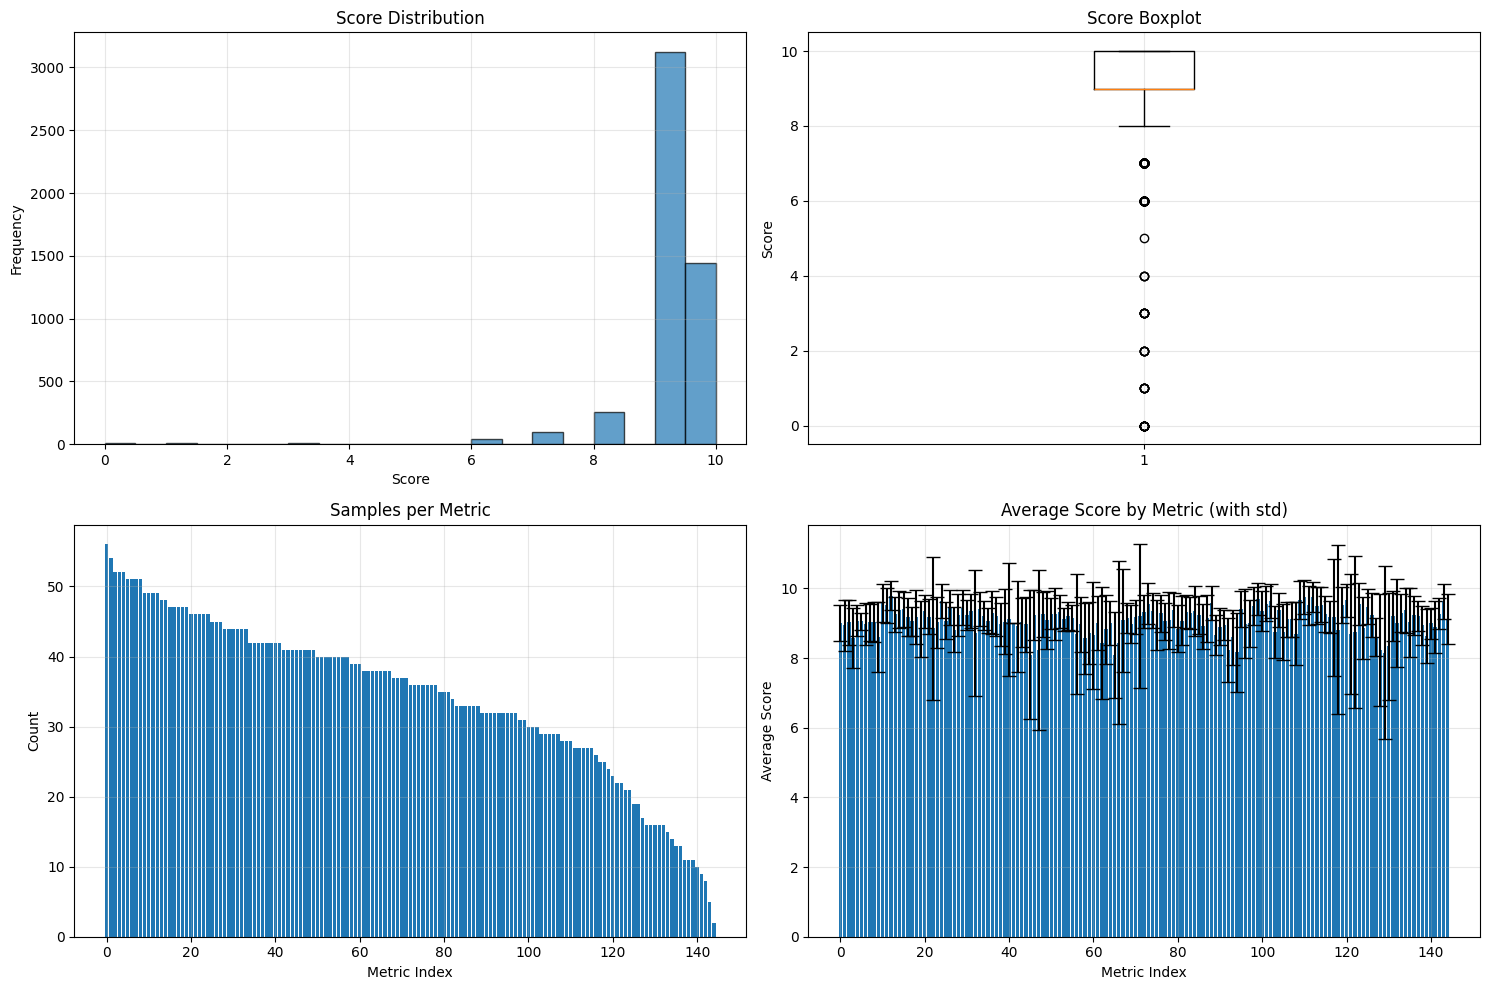

In [80]:
print("SCORE DISTRIBUTION")
print("-"*80)

df['score'] = df['score'].astype(float)
print(f"\nScore Statistics:")
print(df['score'].describe())
print(f"\nScore value counts:")
print(df['score'].value_counts().sort_index())

print(f"\nUnique scores: {sorted(df['score'].unique())}")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Score distribution
axes[0, 0].hist(df['score'], bins=20, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Score Distribution')
axes[0, 0].grid(True, alpha=0.3)

# Score boxplot
axes[0, 1].boxplot(df['score'], vert=True)
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_title('Score Boxplot')
axes[0, 1].grid(True, alpha=0.3)


print("\n" + "="*80)
print("METRIC NAME ANALYSIS")
print("-"*80)

metric_counts = df['metric_name'].value_counts()
print(f"\nNumber of unique metrics: {len(metric_counts)}")
print(f"\nMetric distribution:")
print(metric_counts)

# Score by metric
axes[1, 0].bar(range(len(metric_counts)), metric_counts.values)
axes[1, 0].set_xlabel('Metric Index')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Samples per Metric')
axes[1, 0].grid(True, alpha=0.3)

# Average score per metric
metric_scores = df.groupby('metric_name')['score'].agg(['mean', 'std', 'count'])
print(f"\nScore statistics by metric:")
print(metric_scores)

axes[1, 1].bar(range(len(metric_scores)), metric_scores['mean'].values, 
               yerr=metric_scores['std'].values, capsize=5)
axes[1, 1].set_xlabel('Metric Index')
axes[1, 1].set_ylabel('Average Score')
axes[1, 1].set_title('Average Score by Metric (with std)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


##### Insights:
- Scores are highly skewed toward the upper range (8–10), in which large majority of samples fall between 9.0 and 10.0
- Very few low-score outliers (0–5) exist, with
    - 9.0 -> 3123 samples (largest group)
    - 10.0 -> 1442 samples


TEXT LENGTH ANALYSIS
--------------------------------------------------------------------------------

Prompt length statistics:
count    5000.000000
mean      262.654600
std       171.863811
min        25.000000
25%       150.000000
50%       226.000000
75%       330.000000
max      2149.000000
Name: prompt_len, dtype: float64

Response length statistics:
count     5000.000000
mean       866.884200
std        836.458286
min          0.000000
25%        398.000000
50%        587.000000
75%       1003.000000
max      12985.000000
Name: response_len, dtype: float64


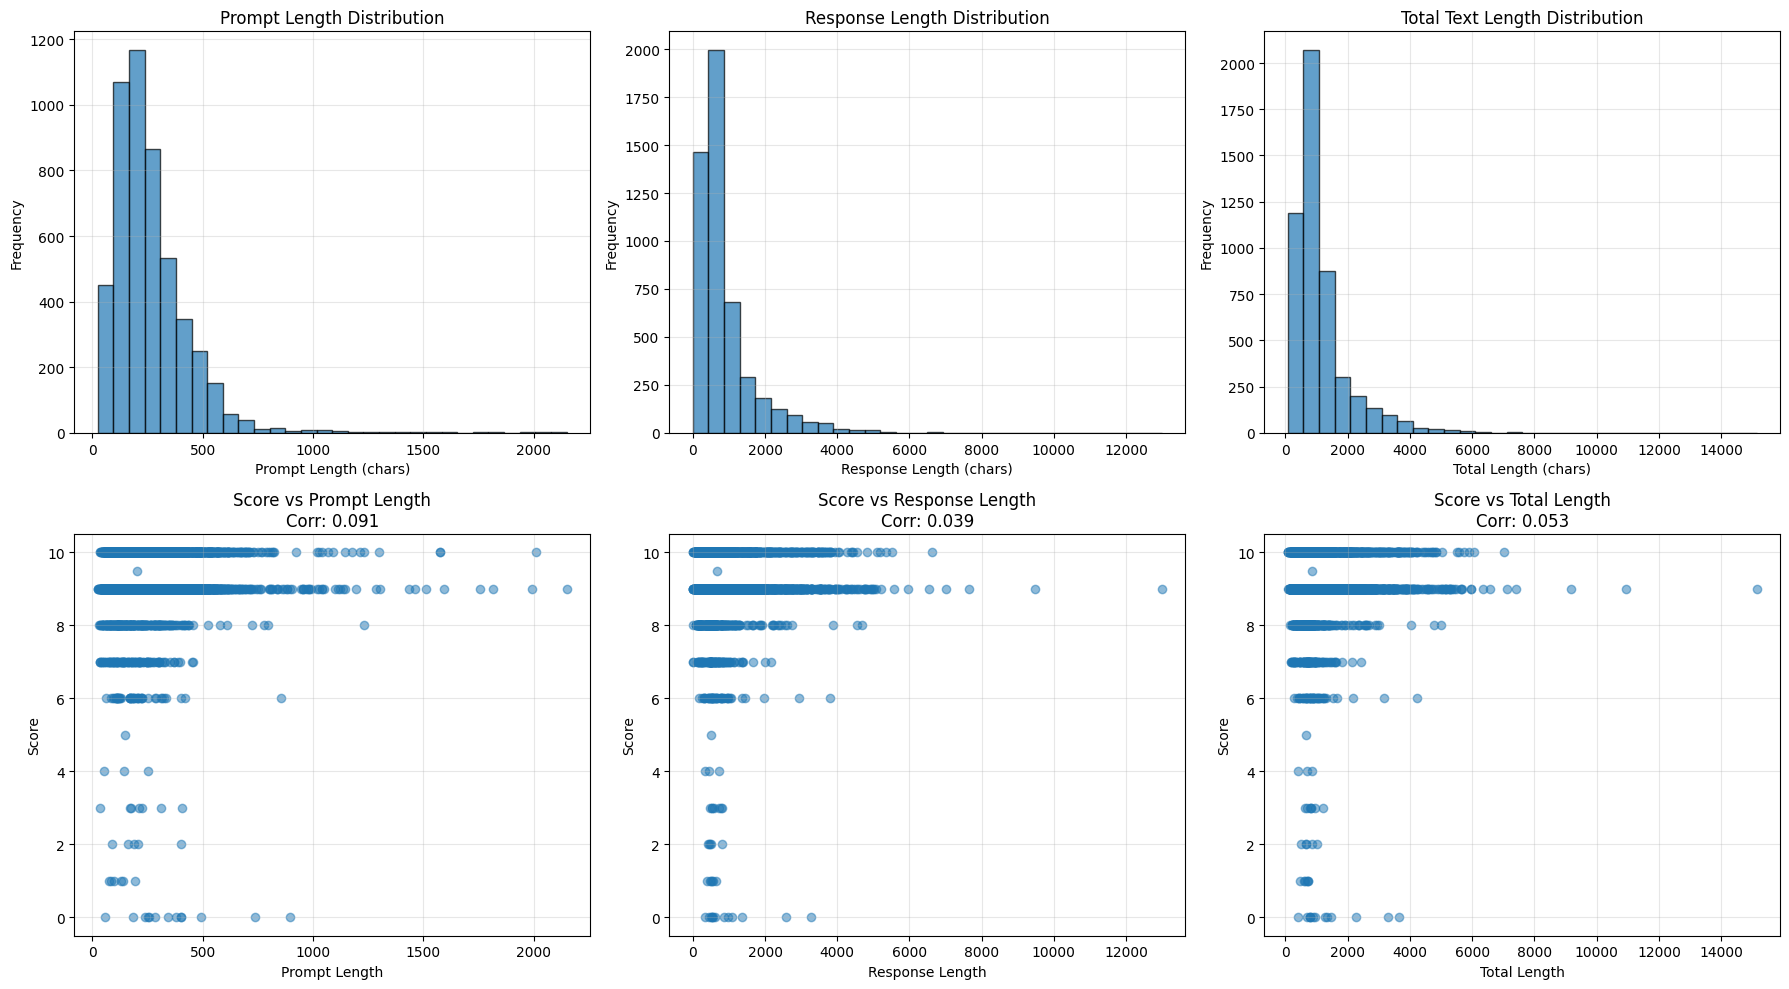

In [19]:

print("TEXT LENGTH ANALYSIS")
print("-"*80)

df['prompt_len'] = df['user_prompt'].fillna('').apply(len)
df['response_len'] = df['response'].fillna('').apply(len)
df['total_len'] = df['prompt_len'] + df['response_len']

print(f"\nPrompt length statistics:")
print(df['prompt_len'].describe())
print(f"\nResponse length statistics:")
print(df['response_len'].describe())

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Prompt length distribution
axes[0, 0].hist(df['prompt_len'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Prompt Length (chars)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Prompt Length Distribution')
axes[0, 0].grid(True, alpha=0.3)

# Response length distribution
axes[0, 1].hist(df['response_len'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Response Length (chars)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Response Length Distribution')
axes[0, 1].grid(True, alpha=0.3)

# Total length distribution
axes[0, 2].hist(df['total_len'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 2].set_xlabel('Total Length (chars)')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Total Text Length Distribution')
axes[0, 2].grid(True, alpha=0.3)

# Correlation with score
axes[1, 0].scatter(df['prompt_len'], df['score'], alpha=0.5)
axes[1, 0].set_xlabel('Prompt Length')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_title(f'Score vs Prompt Length\nCorr: {df["prompt_len"].corr(df["score"]):.3f}')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].scatter(df['response_len'], df['score'], alpha=0.5)
axes[1, 1].set_xlabel('Response Length')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title(f'Score vs Response Length\nCorr: {df["response_len"].corr(df["score"]):.3f}')
axes[1, 1].grid(True, alpha=0.3)

axes[1, 2].scatter(df['total_len'], df['score'], alpha=0.5)
axes[1, 2].set_xlabel('Total Length')
axes[1, 2].set_ylabel('Score')
axes[1, 2].set_title(f'Score vs Total Length\nCorr: {df["total_len"].corr(df["score"]):.3f}')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

##### Insights:
* Prompt Length
    - Prompts are generally short to medium in size, having Median ≈ 226 chars, mean ≈ 263 chars.
    - Majority fall within 150–330 chars.
    - Very long prompts (>1500 chars) are rare outliers.
* Response Length
    - Responses are significantly longer and more variable with Median ≈ 587 chars, mean ≈ 867 chars.
    - Distribution is right-skewed with some extremely long replies (up to 12.9k chars).
    -High variance (std ≈ 836) indicates inconsistent verbosity.
- All correlations are extremely weak. Score is essentially independent of how long the prompt or response is.

LANGUAGE ANALYSIS
--------------------------------------------------------------------------------

Prompt languages:
prompt_lang
hindi          2496
english        1472
bengali         631
mixed/other     401
Name: count, dtype: int64

Response languages:
response_lang
hindi          2499
english        1439
bengali         648
mixed/other     413
unknown           1
Name: count, dtype: int64

Score by prompt language:
                 mean       std  count
prompt_lang                           
bengali      9.169572  0.746267    631
english      9.226223  0.684721   1472
hindi        9.006611  1.044912   2496
mixed/other  9.351621  1.228232    401


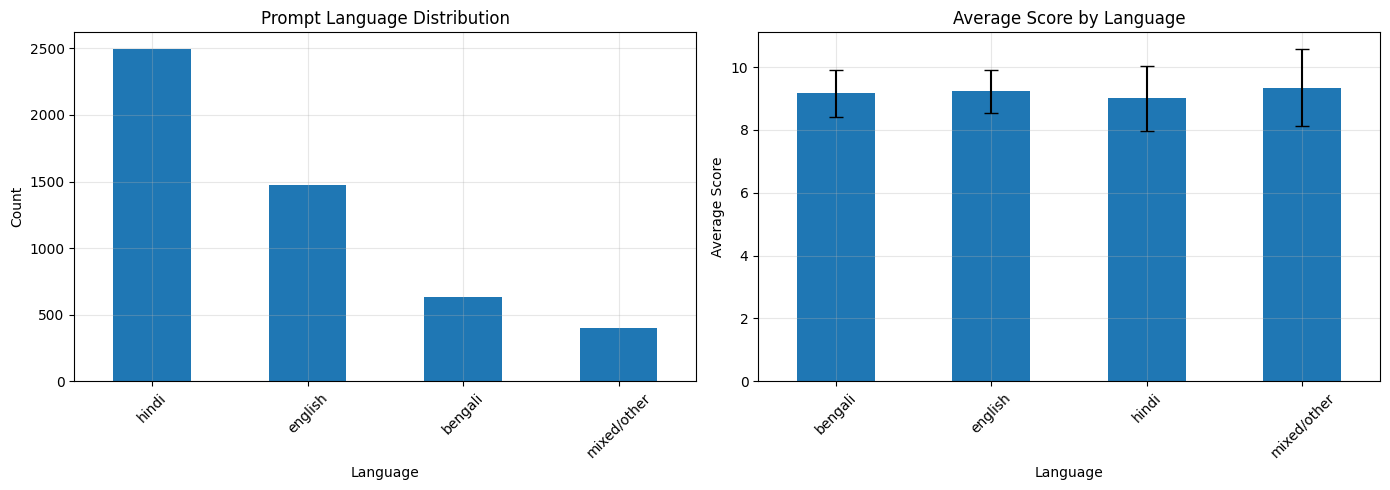

In [26]:

print("LANGUAGE ANALYSIS")
print("-"*80)

def detect_language_simple(text):
    """Simple language detection based on character sets"""
    if not text or pd.isna(text):
        return 'unknown'
    
    # Count character types
    ascii_count = sum(1 for c in text if ord(c) < 128)
    devanagari_count = sum(1 for c in text if '\u0900' <= c <= '\u097F')
    bengali_count = sum(1 for c in text if '\u0980' <= c <= '\u09FF')
    
    total = len(text)
    if total == 0:
        return 'unknown'
    
    ascii_ratio = ascii_count / total
    
    if ascii_ratio > 0.8:
        return 'english'
    elif devanagari_count > total * 0.1:
        return 'hindi'
    elif bengali_count > total * 0.1:
        return 'bengali'
    else:
        return 'mixed/other'

df['prompt_lang'] = df['user_prompt'].apply(detect_language_simple)
df['response_lang'] = df['response'].apply(detect_language_simple)

print(f"\nPrompt languages:")
print(df['prompt_lang'].value_counts())
print(f"\nResponse languages:")
print(df['response_lang'].value_counts())

# Language vs score
lang_scores = df.groupby('prompt_lang')['score'].agg(['mean', 'std', 'count'])
print(f"\nScore by prompt language:")
print(lang_scores)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Language distribution
df['prompt_lang'].value_counts().plot(kind='bar', ax=axes[0])
axes[0].set_xlabel('Language')
axes[0].set_ylabel('Count')
axes[0].set_title('Prompt Language Distribution')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)

# Score by language
lang_scores['mean'].plot(kind='bar', ax=axes[1], yerr=lang_scores['std'], capsize=5)
axes[1].set_xlabel('Language')
axes[1].set_ylabel('Average Score')
axes[1].set_title('Average Score by Language')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

##### Insights:
- Hindi dominates the dataset, followed by English; Bengali and mixed/other are smaller groups.
- High consistency in model performance across all languages (mean scores ≈ 9.0–9.35).
- English and mixed/other prompts score slightly higher, with more stable outputs.
- Hindi shows greater variance, likely due to broader prompt diversity rather than model weakness.
- Bengali performs well, but sample scarcity leads to higher variability.

In [21]:
print("SYSTEM PROMPT ANALYSIS")
print("-"*80)

print(f"\nSystem prompt present: {df['system_prompt'].notna().sum()} samples")
print(f"System prompt absent: {df['system_prompt'].isna().sum()} samples")

df['has_system_prompt'] = df['system_prompt'].notna()
system_prompt_scores = df.groupby('has_system_prompt')['score'].agg(['mean', 'std', 'count'])
print(f"\nScore by system prompt presence:")
print(system_prompt_scores)

SYSTEM PROMPT ANALYSIS
--------------------------------------------------------------------------------

System prompt present: 3451 samples
System prompt absent: 1549 samples

Score by system prompt presence:
                       mean       std  count
has_system_prompt                           
False              9.203357  0.653426   1549
True               9.081860  1.044395   3451


##### Insights:
- The train data misses 1549 system prompt (None)

CORRELATION ANALYSIS
--------------------------------------------------------------------------------

Correlation matrix:
                 score  prompt_len  response_len  total_len
score         1.000000    0.091286      0.039295   0.053205
prompt_len    0.091286    1.000000      0.360769   0.518965
response_len  0.039295    0.360769      1.000000   0.984456
total_len     0.053205    0.518965      0.984456   1.000000


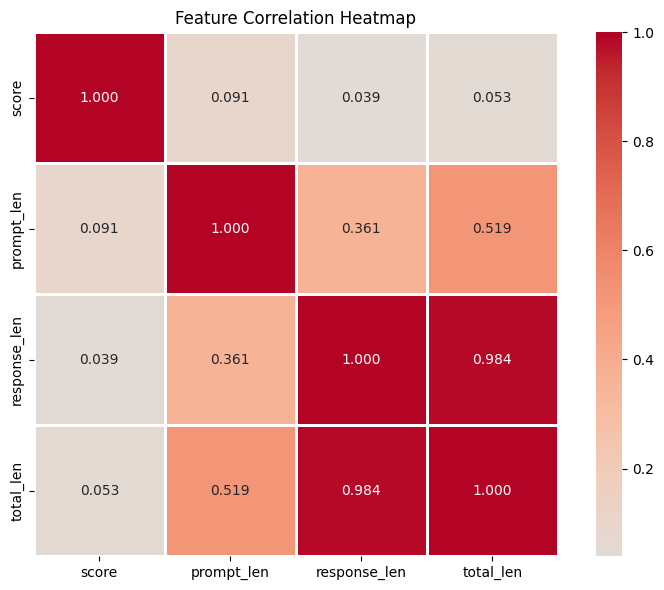

In [23]:
print("CORRELATION ANALYSIS")
print("-"*80)

numeric_cols = ['score', 'prompt_len', 'response_len', 'total_len']
correlation_matrix = df[numeric_cols].corr()
print(f"\nCorrelation matrix:")
print(correlation_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

METRIC CATEGORY ANALYSIS
--------------------------------------------------------------------------------

Number of unique categories: 50

Category distribution:
metric_category
toxicity_level                                                249
misuse                                                        232
bias_detection                                                223
awareness_query                                               206
intent_recognition                                            191
rejection_rate                                                178
confidence_agreement                                          178
inclusivity                                                   176
exaggerated_safety                                            170
privacy_leakage                                               165
inappropriate_content_detection_rate                          161
robustness_against_adversarial_attacks                        159
hallucination_rate           

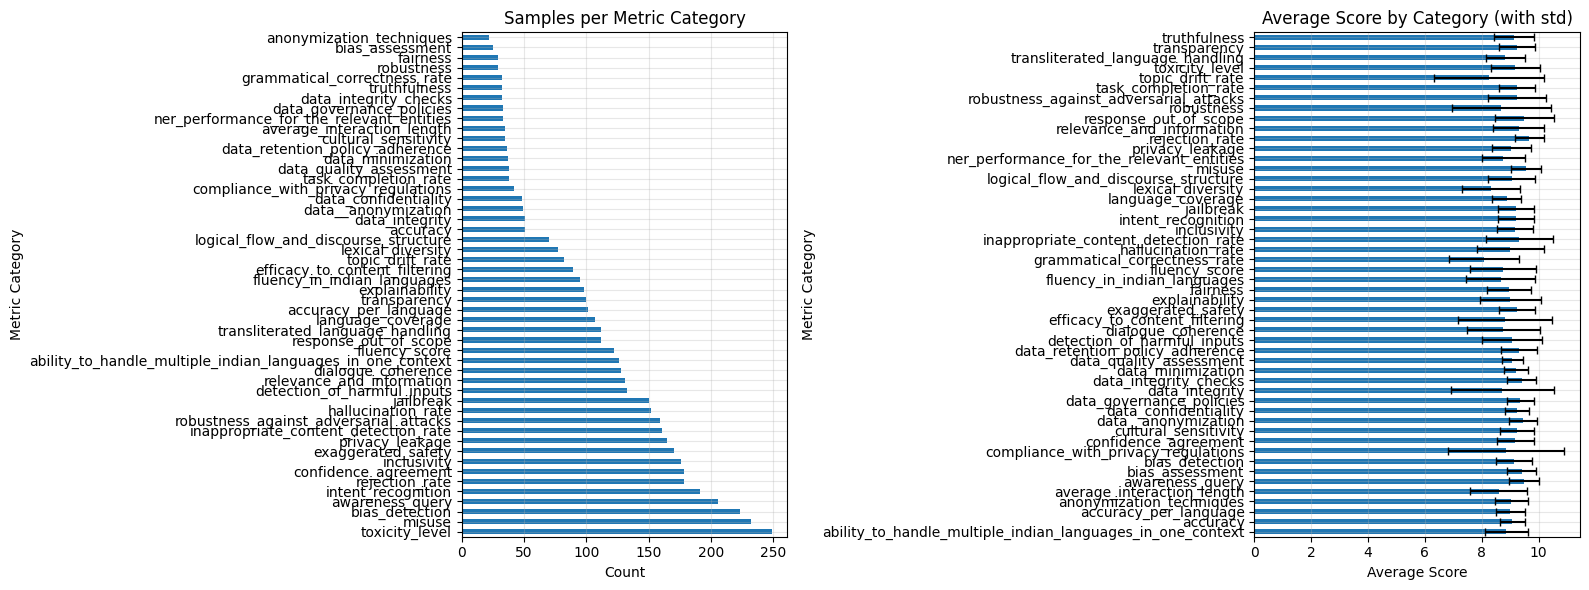

In [25]:
print("METRIC CATEGORY ANALYSIS")
print("-"*80)
df['metric_category'] = df['metric_name'].apply(lambda x: x.split('/')[0] if '/' in x else x)

category_counts = df['metric_category'].value_counts()
print(f"\nNumber of unique categories: {len(category_counts)}")
print(f"\nCategory distribution:")
print(category_counts)

category_scores = df.groupby('metric_category')['score'].agg(['mean', 'std', 'count'])
print(f"\nScore statistics by category:")
print(category_scores)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Category distribution
category_counts.plot(kind='barh', ax=axes[0])
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Metric Category')
axes[0].set_title('Samples per Metric Category')
axes[0].grid(True, alpha=0.3)

# Average score by category
category_scores['mean'].plot(kind='barh', ax=axes[1], 
                              xerr=category_scores['std'], capsize=3)
axes[1].set_xlabel('Average Score')
axes[1].set_ylabel('Metric Category')
axes[1].set_title('Average Score by Category (with std)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()


##### Insights:
* Covers 50 evaluation categories across safety, content quality, linguistic ability, and governance.
* Dataset is skewed toward safety metrics, with governance and privacy metrics appearing far less frequently.
* Model achieves strong overall performance, with most category averages between 8.7–9.6.
* Safety-related metrics (toxicity, misuse, bias detection, intent handling) show high stability and reliability.
* Lower-scoring areas correspond to linguistic nuance and sparsely represented governance categories.
* Indicates a model that is robust in safety-critical scenarios but would benefit from expanded coverage and fine-tuning in governance and advanced linguistic reasoning.


---
## Model Implementation
---

In [3]:
# Utilities: load data + metric embeddings
def load_metric_embeddings(metric_names_json, metric_emb_npy):
    metric_names = json.load(open(metric_names_json, "r", encoding="utf-8"))
    emb = np.load(metric_emb_npy)
    assert len(metric_names) == emb.shape[0], "metric names length must equal embeddings rows"
    return metric_names, emb

def load_json(path):
    return json.load(open(path, "r", encoding="utf-8"))

In [4]:
DEFAULT_EMBED_MODEL = "sentence-transformers/paraphrase-multilingual-mpnet-base-v2"

# Sentence encoder (Gemma)
def get_sentence_transformer(model_name=DEFAULT_EMBED_MODEL, device="cpu"):
    from sentence_transformers import SentenceTransformer
    model = SentenceTransformer(model_name)
    model = model.to(device)
    return model

def encode_texts(model, texts, batch_size=64):
    embs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        emb = model.encode(batch, convert_to_numpy=True, show_progress_bar=False)
        embs.append(emb)
    return np.vstack(embs)

In [5]:
# Dataset
class EvalDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = None if y is None else torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        if self.y is None:
            return self.X[idx]
        return self.X[idx], self.y[idx]
    

# Prepare data and features

def prepare_data(data_dir, embed_model, device, cache_dir, val_frac=0.1, batch_size=64):
    metric_json = os.path.join(data_dir, "metric_names.json")
    metric_emb_npy = os.path.join(data_dir, "metric_name_embeddings.npy")
    train_json = os.path.join(data_dir, "train_data.json")
    test_json = os.path.join(data_dir, "test_data.json")

    assert os.path.exists(metric_json) and os.path.exists(metric_emb_npy), "Metric files missing"
    assert os.path.exists(train_json) and os.path.exists(test_json), "Train/test JSON missing"

    metric_names, metric_embs = load_metric_embeddings(metric_json, metric_emb_npy)
    train_recs = load_json(train_json)
    test_recs = load_json(test_json)

    metric_map = {name: emb for name, emb in zip(metric_names, metric_embs)}

    def combine_text(rec):
        p = rec.get("user_prompt", "") or ""
        s = rec.get("system_prompt", "") or ""
        r = rec.get("response", "") or ""
        parts = [x.strip() for x in [p, s, r] if x and x.strip() != ""]
        return " ||| ".join(parts) if parts else ""

    train_texts = [combine_text(r) for r in train_recs]
    test_texts = [combine_text(r) for r in test_recs]
    all_texts = train_texts + test_texts

    Path(cache_dir).mkdir(parents=True, exist_ok=True)
    text_cache = os.path.join(cache_dir, "all_text_emb.npy")

    if os.path.exists(text_cache):
        print("Loading cached text embeddings:", text_cache)
        all_text_emb = np.load(text_cache)
        assert all_text_emb.shape[0] == len(all_texts)
    else:
        print("Encoding texts with", embed_model)
        st = get_sentence_transformer(embed_model, device=device)
        all_text_emb = encode_texts(st, all_texts, batch_size=64)
        np.save(text_cache, all_text_emb)
        print("Saved text embeddings to cache:", text_cache)

    train_text_emb = all_text_emb[:len(train_texts)]
    test_text_emb = all_text_emb[len(train_texts):]

    def build_matrix(records, text_embs):
        X_list = []
        y_list = []
        for rec, t_emb in zip(records, text_embs):
            mname = rec.get("metric_name", "")
            m_emb = metric_map.get(mname)
            if m_emb is None:
                if "/" in mname:
                    major = mname.split("/")[0].strip()
                    m_emb = metric_map.get(major, np.zeros(metric_embs.shape[1], dtype=np.float32))
                else:
                    m_emb = np.zeros(metric_embs.shape[1], dtype=np.float32)
            feat = np.concatenate([m_emb.astype(np.float32), t_emb.astype(np.float32)], axis=0)
            X_list.append(feat)
            # training key name could be 'score' or 'judge_score' depending on your file; try both
            if "score" in rec:
                y_list.append(float(rec["score"]))
            elif "judge_score" in rec:
                y_list.append(float(rec["judge_score"]))
            else:
                # test records won't have label; skip
                pass
        X = np.vstack(X_list)
        y = np.array(y_list, dtype=np.float32) if len(y_list) else None
        return X, y

    X_train_all, y_train_all = build_matrix(train_recs, train_text_emb)
    X_test, _ = build_matrix(test_recs, test_text_emb)

    if y_train_all is None or len(y_train_all) == 0:
        raise RuntimeError("No training labels found in train_data.json (expected 'score' or 'judge_score')")

    unique_scores = sorted(list(set(y_train_all.tolist()))
)
    print("Unique training scores:", unique_scores)

    label_encoder = LabelEncoder()
    label_encoder.fit(unique_scores)
    y_train_cls_all = label_encoder.transform(y_train_all)  # integer classes 0..C-1

    # train/val split
    N = X_train_all.shape[0]
    idx = np.arange(N)
    rng = np.random.RandomState(42)
    rng.shuffle(idx)
    n_val = int(math.ceil(val_frac * N))
    val_idx = idx[:n_val]
    tr_idx = idx[n_val:]

    X_tr, y_tr = X_train_all[tr_idx], y_train_cls_all[tr_idx]
    X_val, y_val = X_train_all[val_idx], y_train_cls_all[val_idx]

    tr_ds = EvalDataset(X_tr, y_tr)
    val_ds = EvalDataset(X_val, y_val)
    test_ds = EvalDataset(X_test, None)

    tr_loader = DataLoader(tr_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    return tr_loader, val_loader, test_loader, X_train_all.shape[1], label_encoder, y_train_cls_all


In [6]:
# Model (MLP Classifier)
class MLPClassifier(nn.Module):
    def __init__(self, inp_dim, hidden=[1024,512], num_classes=10, dropout=0.2):
        super().__init__()
        layers = []
        d = inp_dim
        for h in hidden:
            layers.append(nn.Linear(d, h))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(dropout))
            d = h
        layers.append(nn.Linear(d, num_classes))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)
    
# Model (MetricNet)

class MetricNet(nn.Module):
    """
    Produces positive per-class weights for each example: shape (B, C)
    """
    def __init__(self, input_dim, num_classes, hidden=[256], eps=1e-6):
        super().__init__()
        layers = []
        d = input_dim
        for h in hidden:
            layers.append(nn.Linear(d, h))
            layers.append(nn.ReLU(inplace=True))
            d = h
        layers.append(nn.Linear(d, num_classes))
        self.net = nn.Sequential(*layers)
        self.eps = eps
    def forward(self, x):
        w = F.softplus(self.net(x)) + self.eps
        return w

In [7]:
# Loss Function
def metricized_crossentropy_balanced(logits, targets, metric_w, fixed_w):
    """
    logits: (B, C)
    targets: (B,)
    metric_w: (B, C)
    fixed_w: (C,) or (1, C)
    """
    B, C = logits.shape
    log_probs = F.log_softmax(logits, dim=1)           # (B, C)
    one_hot = F.one_hot(targets, num_classes=C).float()# (B, C)
    if fixed_w.dim() == 1:
        fixed_w = fixed_w.view(1, -1)
    w = metric_w * fixed_w  # (B, C)
    loss = -(w * one_hot * log_probs).sum(dim=1)       # (B,)
    return loss.mean()

# Model evaluation
def evaluate_classifier(model, loader, device):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for X, y in loader:
            X = X.to(device)
            logits = model(X)
            cls = logits.argmax(dim=1).cpu().numpy()
            preds.extend(cls)
            trues.extend(y.numpy())
    acc = accuracy_score(trues, preds) if len(trues) else 0.0
    return acc

# Class-balanced fixed weights (effective number)

def compute_class_balanced_weights(y_train_cls, num_classes, beta=0.9995, eps=1e-12):
    counts = Counter(int(x) for x in y_train_cls)
    weights = np.zeros(num_classes, dtype=np.float32)
    for c in range(num_classes):
        n = counts.get(c, 0)
        if n > 0:
            weights[c] = (1.0 - beta) / (1.0 - (beta ** n))
        else:
            weights[c] = 0.0
    # normalize to have mean 1 (so scale of loss remains comparable)
    total = weights.sum()
    if total <= 0:
        # fallback uniform
        weights = np.ones(num_classes, dtype=np.float32)
    else:
        weights = weights / (weights.mean() + eps)
    return torch.tensor(weights, dtype=torch.float32)

# Save submission

def save_submission(model, test_loader, label_encoder, out_file, device="cpu"):
    model.eval()
    preds = []
    with torch.no_grad():
        for X in test_loader:
            X = X.to(device)
            logits = model(X)
            cls = logits.argmax(dim=1).cpu().numpy()
            scores = label_encoder.inverse_transform(cls)
            preds.extend([float(x) for x in scores])
    df = pd.DataFrame({"ID": list(range(1, len(preds) + 1)), "score": preds})
    df.to_csv(out_file, index=False)
    print("Saved submission to:", out_file)

In [8]:
# Bilevel training (unrolled) with balanced metric-weighted loss

def train_taskmet_unrolled_classification(
    tr_loader, val_loader, classifier, metric_net, label_encoder, fixed_class_weights,
    device="cpu", inner_steps=5, inner_lr=1e-2, outer_lr=1e-4, epochs=5, sync_alpha=0.1
):
    classifier.to(device)
    metric_net.to(device)
    fixed_class_weights = fixed_class_weights.to(device)
    outer_opt = torch.optim.Adam(metric_net.parameters(), lr=outer_lr)

    for ep in range(1, epochs + 1):
        classifier.train()
        metric_net.train()
        running_loss = 0.0
        nb = 0
        for X_batch, y_batch in tr_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            # clone classifier for inner updates
            inner_model = copy.deepcopy(classifier).to(device)

            # unrolled inner updates
            for k in range(inner_steps):
                logits = inner_model(X_batch)                          # (B, C)
                metric_w = metric_net(X_batch)                        # (B, C)
                inner_loss = metricized_crossentropy_balanced(logits, y_batch, metric_w, fixed_class_weights)
                grads = torch.autograd.grad(inner_loss, inner_model.parameters(), create_graph=True)
                with torch.no_grad():
                    for p, g in zip(inner_model.parameters(), grads):
                        if g is None:
                            continue
                        p -= inner_lr * g

            # outer loss: based on final inner_model predictions and metric_net
            logits_final = inner_model(X_batch)
            metric_w_final = metric_net(X_batch)
            outer_loss = metricized_crossentropy_balanced(logits_final, y_batch, metric_w_final, fixed_class_weights)

            outer_opt.zero_grad()
            outer_loss.backward()
            outer_opt.step()

            # soft-sync classifier toward inner_model
            with torch.no_grad():
                for p_main, p_inner in zip(classifier.parameters(), inner_model.parameters()):
                    p_main.data.mul_(1.0 - sync_alpha).add_(sync_alpha * p_inner.data)

            running_loss += outer_loss.item() * X_batch.shape[0]
            nb += X_batch.shape[0]

        avg_loss = running_loss / max(1, nb)
        val_acc = evaluate_classifier(classifier, val_loader, device)
        print(f"[Epoch {ep}] train_task_loss={avg_loss:.4f} | val_acc={val_acc:.4f}")

    return classifier, metric_net


# Baseline classifier training (cross-entropy)

def train_baseline_classifier(model, tr_loader, val_loader, device="cpu", epochs=5, lr=1e-4, class_weights=None):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    if class_weights is not None:
        criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    else:
        criterion = nn.CrossEntropyLoss()
    for ep in range(1, epochs + 1):
        model.train()
        total_loss = 0.0
        n = 0
        for X, y in tr_loader:
            X = X.to(device); y = y.to(device)
            optimizer.zero_grad()
            logits = model(X)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * X.shape[0]
            n += X.shape[0]
        avg_loss = total_loss / max(1, n)
        val_acc = evaluate_classifier(model, val_loader, device)
        print(f"[Baseline E{ep}] train_loss={avg_loss:.4f} val_acc={val_acc:.4f}")
    return model

In [ ]:
import math
# Main Function
def main():
    parser = argparse.ArgumentParser()
    args = parser.parse_args([])
    args.data_dir = './da5401-2025-data-challenge'
    args.device = 'cuda'
    args.epochs = 100
    args.batch_size = 16
    args.out_dir = './output_taskmet'
    args.seed = 42
    args.embed_model = "google/embeddinggemma-300m"
    args.mode = 'taskmet'
    args.inner_steps = 5
    args.inner_lr = 1e-2
    args.outer_lr = 1e-4

    #random.seed(args.seed); np.random.seed(args.seed); torch.manual_seed(args.seed)
    
    os.makedirs(args.out_dir, exist_ok=True)
    cache_dir = os.path.join(args.out_dir, "cache")
    tr_loader, val_loader, test_loader, input_dim, label_encoder, y_train_cls_all = prepare_data(
        args.data_dir, args.embed_model, args.device, cache_dir, val_frac=0.1, batch_size=args.batch_size
    )

    num_classes = len(label_encoder.classes_)
    print("num_classes:", num_classes, "feature_dim:", input_dim)

    fixed_class_weights = compute_class_balanced_weights(y_train_cls_all, num_classes=num_classes, beta=0.9995)
    print("Fixed class-balanced weights (normalized mean=1):", fixed_class_weights.numpy())

    if args.mode == "baseline":
        print("Training baseline classifier (class-weighted)...")
        model = MLPClassifier(input_dim, hidden=[1024,512], num_classes=num_classes, dropout=0.2).to(args.device)
        # optional: use fixed_class_weights in CrossEntropyLoss to help imbalance
        model = train_baseline_classifier(model, tr_loader, val_loader, device=args.device, epochs=args.epochs, lr=1e-4,)# class_weights=fixed_class_weights)
        torch.save(model.state_dict(), os.path.join(args.out_dir, "baseline_classifier.pth"))
        save_submission(model, test_loader, label_encoder, os.path.join(args.out_dir, "submission_baseline.csv"), device=args.device)

    else:
        print("Training TaskMet (classification, unrolled + balanced)...")
        classifier = MLPClassifier(input_dim, hidden=[1024,512], num_classes=num_classes, dropout=0.2).to(args.device)
        metric_net = MetricNet(input_dim, num_classes=num_classes, hidden=[256]).to(args.device)
        classifier, metric_net = train_taskmet_unrolled_classification(
            tr_loader, val_loader, classifier, metric_net, label_encoder, fixed_class_weights,
            device=args.device, inner_steps=args.inner_steps, inner_lr=args.inner_lr, outer_lr=args.outer_lr, epochs=args.epochs, sync_alpha=0.1
        )
        torch.save(classifier.state_dict(), os.path.join(args.out_dir, "taskmet_classifier.pth"))
        torch.save(metric_net.state_dict(), os.path.join(args.out_dir, "taskmet_metricnet.pth"))
        save_submission(classifier, test_loader, label_encoder, os.path.join(args.out_dir, "submission_taskmet.csv"), device=args.device)

if __name__ == "__main__":
    from huggingface_hub import login
    login("User_access_token")
    main()


Loading cached text embeddings: ./output_taskmet/cache/all_text_emb.npy
Unique training scores: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 9.5, 10.0]
num_classes: 12 feature_dim: 1536
Fixed class-balanced weights (normalized mean=1): [3.1281176e-01 6.7657441e-01 8.1168640e-01 5.8006591e-01 1.3521345e+00
 4.0543756e+00 9.1092102e-02 4.3688588e-02 1.6685518e-02 2.5652135e-03
 4.0543756e+00 3.9453120e-03]
Training TaskMet (classification, unrolled + balanced)...
[Epoch 1] train_task_loss=0.0180 | val_acc=0.0200
[Epoch 2] train_task_loss=0.0122 | val_acc=0.0200
[Epoch 3] train_task_loss=0.0078 | val_acc=0.0200
[Epoch 4] train_task_loss=0.0052 | val_acc=0.0200
[Epoch 5] train_task_loss=0.0035 | val_acc=0.0200
[Epoch 6] train_task_loss=0.0025 | val_acc=0.0200
[Epoch 7] train_task_loss=0.0018 | val_acc=0.0200
[Epoch 8] train_task_loss=0.0013 | val_acc=0.0200
[Epoch 9] train_task_loss=0.0010 | val_acc=0.0200
[Epoch 10] train_task_loss=0.0007 | val_acc=0.0200
[Epoch 11] train_task_loss=

In [ ]:
import math
# Main Function
def main():
    parser = argparse.ArgumentParser()
    args = parser.parse_args([])
    args.data_dir = './da5401-2025-data-challenge'
    args.device = 'cuda'
    args.epochs = 20
    args.batch_size = 16
    args.out_dir = './output_taskmet'
    args.seed = 42
    args.embed_model = "google/embeddinggemma-300m"
    args.mode = 'baseline'
    args.inner_steps = 5
    args.inner_lr = 1e-2
    args.outer_lr = 1e-4

    #random.seed(args.seed); np.random.seed(args.seed); torch.manual_seed(args.seed)
    
    os.makedirs(args.out_dir, exist_ok=True)
    cache_dir = os.path.join(args.out_dir, "cache")
    tr_loader, val_loader, test_loader, input_dim, label_encoder, y_train_cls_all = prepare_data(
        args.data_dir, args.embed_model, args.device, cache_dir, val_frac=0.1, batch_size=args.batch_size
    )

    num_classes = len(label_encoder.classes_)
    print("num_classes:", num_classes, "feature_dim:", input_dim)

    fixed_class_weights = compute_class_balanced_weights(y_train_cls_all, num_classes=num_classes, beta=0.9995)
    print("Fixed class-balanced weights (normalized mean=1):", fixed_class_weights.numpy())

    if args.mode == "baseline":
        print("Training baseline classifier (class-weighted)...")
        model = MLPClassifier(input_dim, hidden=[1024,512], num_classes=num_classes, dropout=0.2).to(args.device)
        # optional: use fixed_class_weights in CrossEntropyLoss to help imbalance
        model = train_baseline_classifier(model, tr_loader, val_loader, device=args.device, epochs=args.epochs, lr=1e-4, class_weights=fixed_class_weights)
        torch.save(model.state_dict(), os.path.join(args.out_dir, "baseline_classifier.pth"))
        save_submission(model, test_loader, label_encoder, os.path.join(args.out_dir, "submission_baseline.csv"), device=args.device)

    else:
        print("Training TaskMet (classification, unrolled + balanced)...")
        classifier = MLPClassifier(input_dim, hidden=[1024,512], num_classes=num_classes, dropout=0.2).to(args.device)
        metric_net = MetricNet(input_dim, num_classes=num_classes, hidden=[256]).to(args.device)
        classifier, metric_net = train_taskmet_unrolled_classification(
            tr_loader, val_loader, classifier, metric_net, label_encoder, fixed_class_weights,
            device=args.device, inner_steps=args.inner_steps, inner_lr=args.inner_lr, outer_lr=args.outer_lr, epochs=args.epochs, sync_alpha=0.1
        )
        torch.save(classifier.state_dict(), os.path.join(args.out_dir, "taskmet_classifier.pth"))
        torch.save(metric_net.state_dict(), os.path.join(args.out_dir, "taskmet_metricnet.pth"))
        save_submission(classifier, test_loader, label_encoder, os.path.join(args.out_dir, "submission_taskmet.csv"), device=args.device)

if __name__ == "__main__":
    from huggingface_hub import login
    login("User_access_token")
    main()


Loading cached text embeddings: ./output_taskmet/cache/all_text_emb.npy
Unique training scores: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 9.5, 10.0]
num_classes: 12 feature_dim: 1536
Fixed class-balanced weights (normalized mean=1): [3.1281176e-01 6.7657441e-01 8.1168640e-01 5.8006591e-01 1.3521345e+00
 4.0543756e+00 9.1092102e-02 4.3688588e-02 1.6685518e-02 2.5652135e-03
 4.0543756e+00 3.9453120e-03]
Training baseline classifier (class-weighted)...
[Baseline E1] train_loss=1.9599 val_acc=0.6380
[Baseline E2] train_loss=1.7599 val_acc=0.6520
[Baseline E3] train_loss=1.6515 val_acc=0.6500
[Baseline E4] train_loss=1.5920 val_acc=0.6260
[Baseline E5] train_loss=1.5413 val_acc=0.6080
[Baseline E6] train_loss=1.4878 val_acc=0.5760
[Baseline E7] train_loss=1.4286 val_acc=0.6300
[Baseline E8] train_loss=1.3729 val_acc=0.5760
[Baseline E9] train_loss=1.3508 val_acc=0.6080
[Baseline E10] train_loss=1.2745 val_acc=0.5520
[Baseline E11] train_loss=1.2359 val_acc=0.5620
[Baseline E12] tra

In [ ]:
import math
# Main Function
def main():
    parser = argparse.ArgumentParser()
    args = parser.parse_args([])
    args.data_dir = './da5401-2025-data-challenge'
    args.device = 'cuda'
    args.epochs = 20
    args.batch_size = 16
    args.out_dir = './output_taskmet'
    args.seed = 42
    args.embed_model = "google/embeddinggemma-300m"
    args.mode = 'taskmet'
    args.inner_steps = 5
    args.inner_lr = 1e-2
    args.outer_lr = 1e-4

    #random.seed(args.seed); np.random.seed(args.seed); torch.manual_seed(args.seed)
    
    os.makedirs(args.out_dir, exist_ok=True)
    cache_dir = os.path.join(args.out_dir, "cache")
    tr_loader, val_loader, test_loader, input_dim, label_encoder, y_train_cls_all = prepare_data(
        args.data_dir, args.embed_model, args.device, cache_dir, val_frac=0.1, batch_size=args.batch_size
    )

    num_classes = len(label_encoder.classes_)
    print("num_classes:", num_classes, "feature_dim:", input_dim)

    fixed_class_weights = compute_class_balanced_weights(y_train_cls_all, num_classes=num_classes, beta=0.9995)
    print("Fixed class-balanced weights (normalized mean=1):", fixed_class_weights.numpy())

    if args.mode == "baseline":
        print("Training baseline classifier (class-non weighted)...")
        model = MLPClassifier(input_dim, hidden=[1024,512], num_classes=num_classes, dropout=0.2).to(args.device)
        # optional: use fixed_class_weights in CrossEntropyLoss to help imbalance
        model = train_baseline_classifier(model, tr_loader, val_loader, device=args.device, epochs=args.epochs, lr=1e-4, class_weights='')
        torch.save(model.state_dict(), os.path.join(args.out_dir, "baseline_classifier.pth"))
        save_submission(model, test_loader, label_encoder, os.path.join(args.out_dir, "submission_baseline.csv"), device=args.device)

    else:
        print("Training TaskMet (classification, unrolled + balanced)...")
        classifier = MLPClassifier(input_dim, hidden=[1024,512], num_classes=num_classes, dropout=0.2).to(args.device)
        metric_net = MetricNet(input_dim, num_classes=num_classes, hidden=[256]).to(args.device)
        classifier, metric_net = train_taskmet_unrolled_classification(
            tr_loader, val_loader, classifier, metric_net, label_encoder, fixed_class_weights,
            device=args.device, inner_steps=args.inner_steps, inner_lr=args.inner_lr, outer_lr=args.outer_lr, epochs=args.epochs, sync_alpha=0.1
        )
        torch.save(classifier.state_dict(), os.path.join(args.out_dir, "taskmet_classifier.pth"))
        torch.save(metric_net.state_dict(), os.path.join(args.out_dir, "taskmet_metricnet.pth"))
        save_submission(classifier, test_loader, label_encoder, os.path.join(args.out_dir, "submission_taskmet.csv"), device=args.device)

if __name__ == "__main__":
    from huggingface_hub import login
    login("User_access_token")
    main()


Loading cached text embeddings: ./output_taskmet/cache/all_text_emb.npy
Unique training scores: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 9.5, 10.0]
num_classes: 12 feature_dim: 1536
Fixed class-balanced weights (normalized mean=1): [3.1281176e-01 6.7657441e-01 8.1168640e-01 5.8006591e-01 1.3521345e+00
 4.0543756e+00 9.1092102e-02 4.3688588e-02 1.6685518e-02 2.5652135e-03
 4.0543756e+00 3.9453120e-03]
Training TaskMet (classification, unrolled + balanced)...
[Epoch 1] train_task_loss=0.0176 | val_acc=0.1480
[Epoch 2] train_task_loss=0.0117 | val_acc=0.1460
[Epoch 3] train_task_loss=0.0071 | val_acc=0.1340
[Epoch 4] train_task_loss=0.0045 | val_acc=0.1320
[Epoch 5] train_task_loss=0.0029 | val_acc=0.1260
[Epoch 6] train_task_loss=0.0020 | val_acc=0.1300
[Epoch 7] train_task_loss=0.0014 | val_acc=0.1280
[Epoch 8] train_task_loss=0.0010 | val_acc=0.1280
[Epoch 9] train_task_loss=0.0007 | val_acc=0.1280
[Epoch 10] train_task_loss=0.0005 | val_acc=0.1280
[Epoch 11] train_task_loss=

In [ ]:
# Compare Submission
from sklearn.metrics import confusion_matrix,classification_report
sample_path = '/kaggle/input/data-5401/sample_submission.csv'
output_path = '/kaggle/working/output/submission_taskmet.csv'
act_labels = pd.read_csv(sample_path)['score']
pred_labels = pd.read_csv(output_path)['score']
mse = np.mean((pred_labels - act_labels)**2)
rmse = np.sqrt(mse)
#confusion_matrix(act_labels, pred_labels)
print(classification_report(act_labels, pred_labels))
print("rmse:",rmse)